this notebook partially reproduces Figure 9 of the 2010 paper.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.io import loadmat

from torchvision.utils import make_grid
from torch import FloatTensor

from pc_v1 import dir_dictionary
from pc_v1 import io, core

In [3]:
180/22.5

8.0

In [4]:
# first, show all the filters.
w_ff_on, w_ff_off = io.dim_conv_v1_filter_definitions()

In [5]:
# adapted from <https://github.com/leelabcnbc/cnn-v1-jcns2018/blob/master/fig7_cnn.ipynb>
def imshow_pytorch(npimg, figsize=(8, 6), title=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

In [6]:
def plot_groups_of_lines(xdata, data, names, style, *, ax=None, xlog=False):
    if ax is None:
        ax = plt.gca()
    assert len(data) == len(names)

    if isinstance(style, str):
        style = [style]*len(data)
    assert len(data) == len(names)

    for idx, (data_this, name_this, style_this) in enumerate(zip(data, names, style)):
        ax.plot(xdata, data_this, label=name_this, linewidth=(idx+1)*2,
                 marker=style_this)
    
    if xlog:
        ax.set_xscale('log')
    
    ax.legend(loc='best')

In [7]:
# fig 5a. basic tuning properties.
# mostly copied from `test_v1_orientation_tuning_contrast` of `/debug/V1_ResponseProperties/test_core.py`
def fig9_inner(patch_diam, iterations, title=None, bias=-1):
    if title is not None:
        print(title)
    
    grating_wavel=6
    phase=0
    
    
    contrast_hi=0.5
    context_angles=np.linspace(-90,90, num=9,endpoint=True)
    
    im_all = []
    response_all = []
    response_all_init = []
    maxdiam=24
    
#     bias = -1 if not one_off else -2
    fetch_loc = maxdiam*3//2+bias
    print('fetch', fetch_loc, 'out of', maxdiam*3)
    
    for j in range(2):
        response_this_contrast = []
        response_this_contrast_init = []
        for i, ca in enumerate(context_angles):
            if j == 0:
                im_this_inner = io.image_contextual_surround(patch_diam,0,patch_diam,grating_wavel,
                                                       grating_wavel,ca,phase,phase,
                                                       contrast_hi,contrast_hi)
            else:
                assert j == 1
                im_this_inner = io.image_circular_grating(patch_diam,patch_diam,grating_wavel,ca,phase,
                                                    contrast_hi)
                
            # %pad image so that they are the same size regardless of patch diameter
            # Yimeng: I use the way in my previous work. Not sure if equivalent to his.
            assert im_this_inner.shape == (im_this_inner.shape[0], im_this_inner.shape[0])
            diam_im_this_inner = im_this_inner.shape[0]
            im_this = np.full((maxdiam*3, maxdiam*3), fill_value=0.5, dtype=np.float64)
            box_t = int(np.floor((maxdiam*3 - diam_im_this_inner) / 2.0))
            im_this[box_t:box_t+diam_im_this_inner, box_t:box_t+diam_im_this_inner] = im_this_inner
            im_all.append(im_this.copy())
            im_on, im_off = io.preprocess_image(im_this)
            y_init = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=1, verbose=False)
            y_full = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=iterations, verbose=False)
            assert y_full.shape == (iterations, 32, maxdiam*3, maxdiam*3)
            assert y_init.shape == (1, 32, maxdiam*3, maxdiam*3)
            # -1 to match MATLAB.
#             # well but I don't mind it. I think all approaches are essentially the same.
            # Oh fuck... actually they have great differences...
            response_this_contrast.append(y_full[:,0,fetch_loc,fetch_loc].mean())
            response_this_contrast_init.append(y_init[0,0,fetch_loc,fetch_loc])
        response_all.append(response_this_contrast)
        response_all_init.append(response_this_contrast_init)
#     # show all the gratings.
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=9, normalize=False),
                  title='test images', figsize=(16, 5))
    
    # plot
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20, 10))
    plot_groups_of_lines(context_angles, np.asarray(response_all),
                         ['surround', 'center'], ['o', 'x'], ax=axes[0])
    axes[0].set_title('full response')
    
    plot_groups_of_lines(context_angles, np.asarray(response_all_init),
                         ['surround', 'center'], ['o', 'x'], ax=axes[1])
    axes[1].set_title('init response')
    plt.show()

In [8]:
def fig9_wrapper():
    fig9_inner(7, 12, '9a')
    fig9_inner(7, 12, '9a_one_off', 0)
    fig9_inner(7, 12, '9a_one_off_other', -2)
    fig9_inner(11, 8, '9b')
    fig9_inner(11, 8, '9b_one_off', 0)
    fig9_inner(11, 8, '9b_one_off_other', -2)
    fig9_inner(11, 16, '9b_longer')
    fig9_inner(11, 16, '9b_longer_one_off', 0)
    fig9_inner(11, 16, '9b_longer_one_off_other', -2)
    fig9_inner(13, 12, '9c')
    fig9_inner(13, 12, '9c_one_off', 0)
    fig9_inner(13, 12, '9c_one_off_other', -2)
    fig9_inner(17, 16, '9d')
    fig9_inner(17, 16, '9d_one_off', 0)
    fig9_inner(17, 16, '9d_one_off_other', -2)
    fig9_inner(19, 16, '9e')
    fig9_inner(19, 16, '9e_one_off', 0)
    fig9_inner(19, 16, '9e_one_off_other', -2)

9a
fetch 35 out of 72


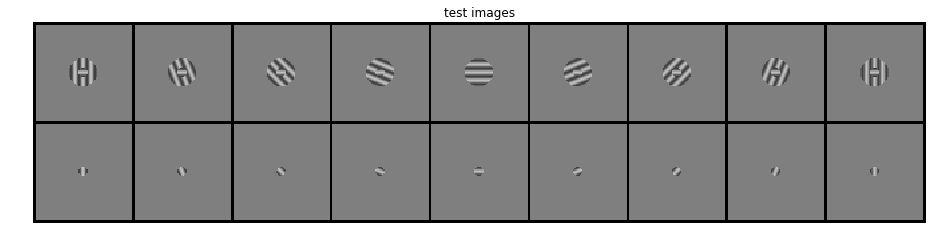

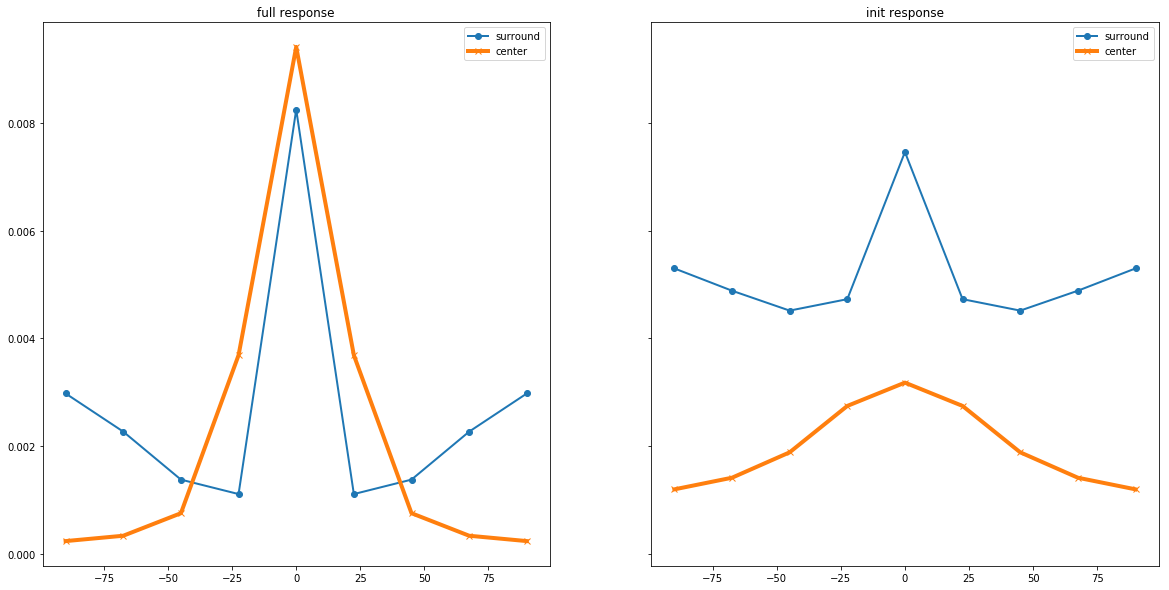

9a_one_off
fetch 36 out of 72


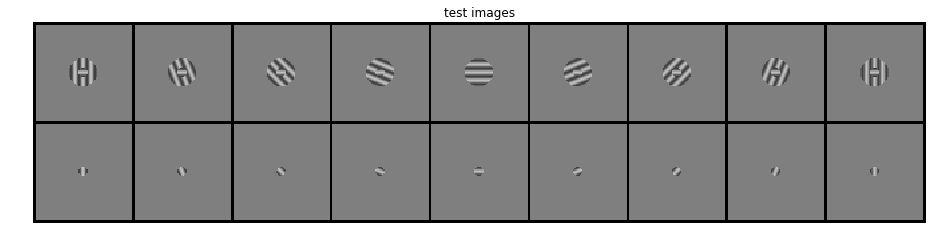

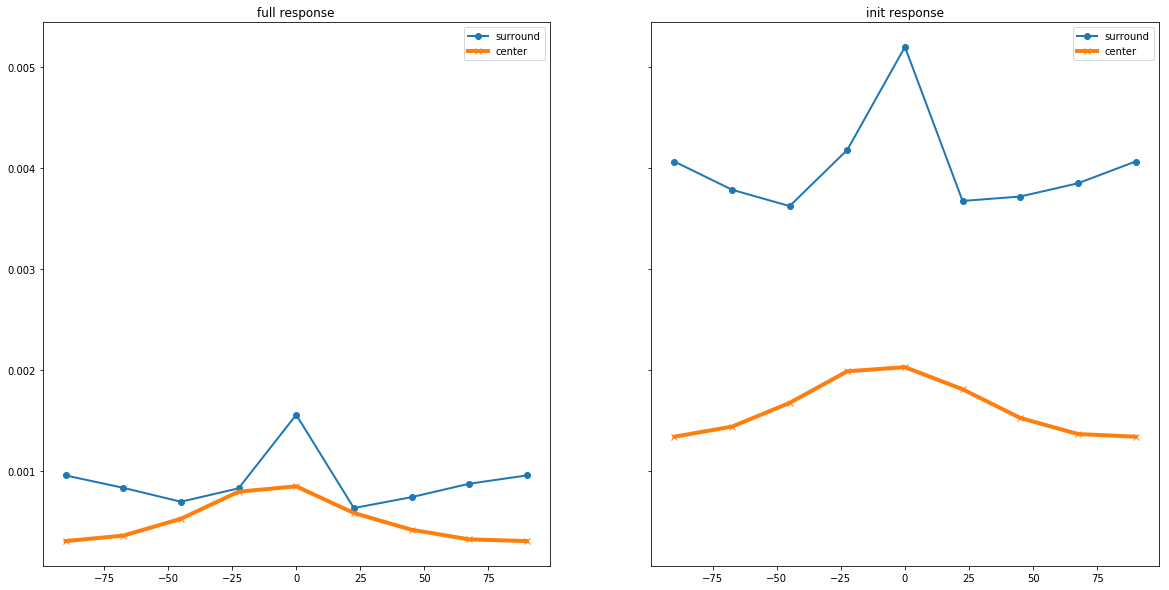

9a_one_off_other
fetch 34 out of 72


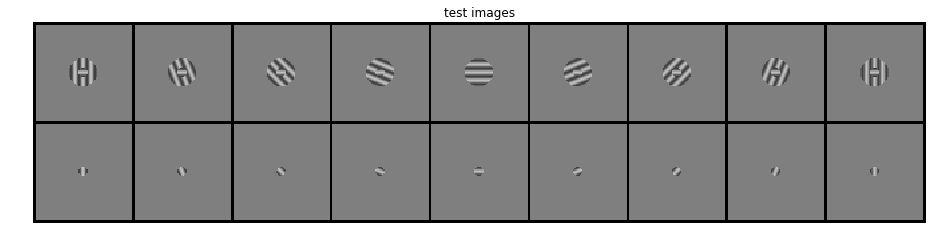

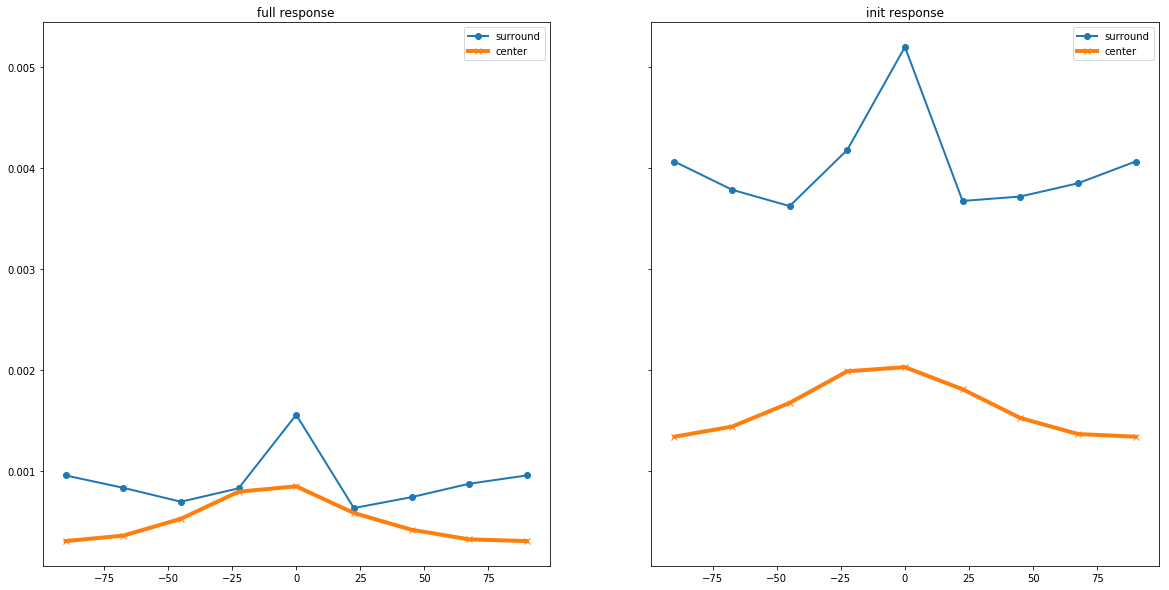

9b
fetch 35 out of 72


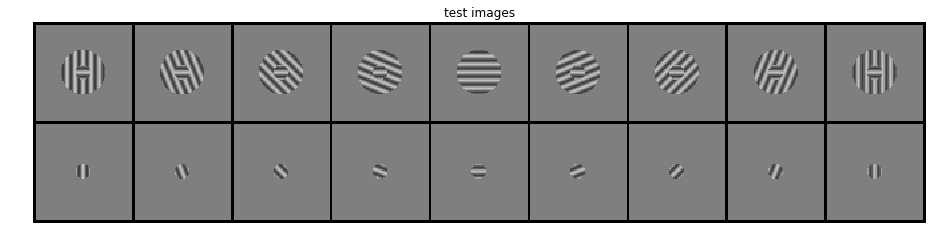

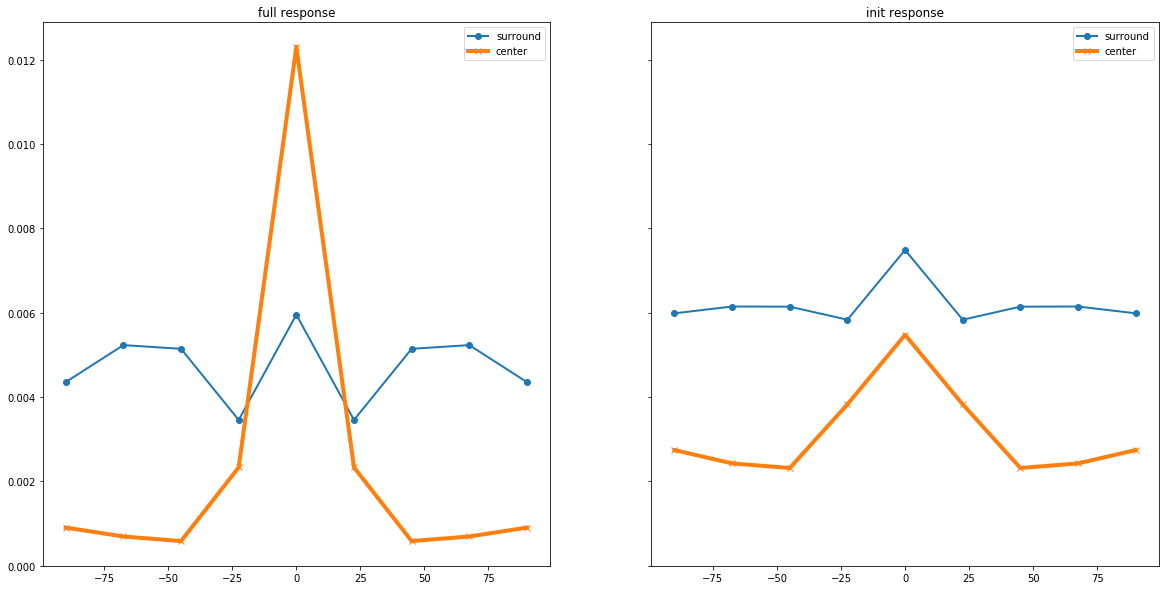

9b_one_off
fetch 36 out of 72


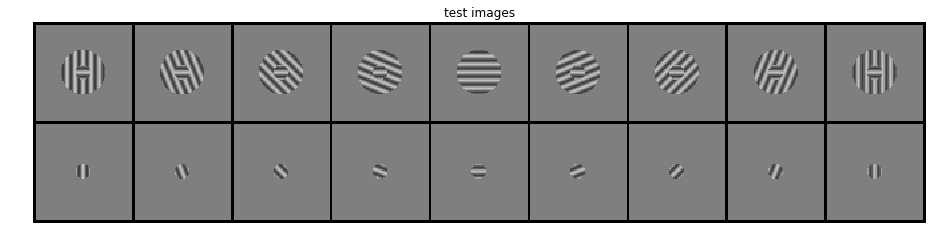

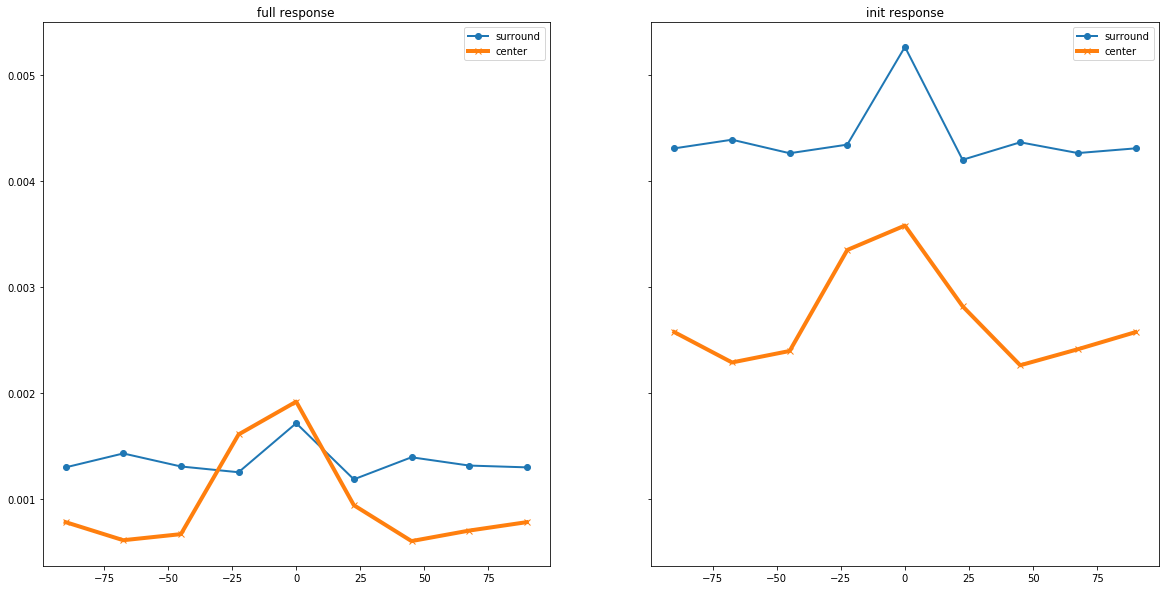

9b_one_off_other
fetch 34 out of 72


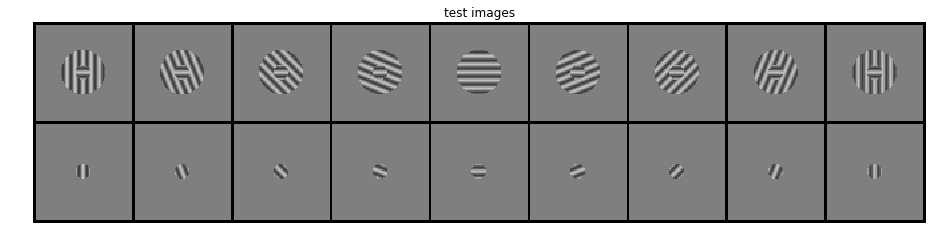

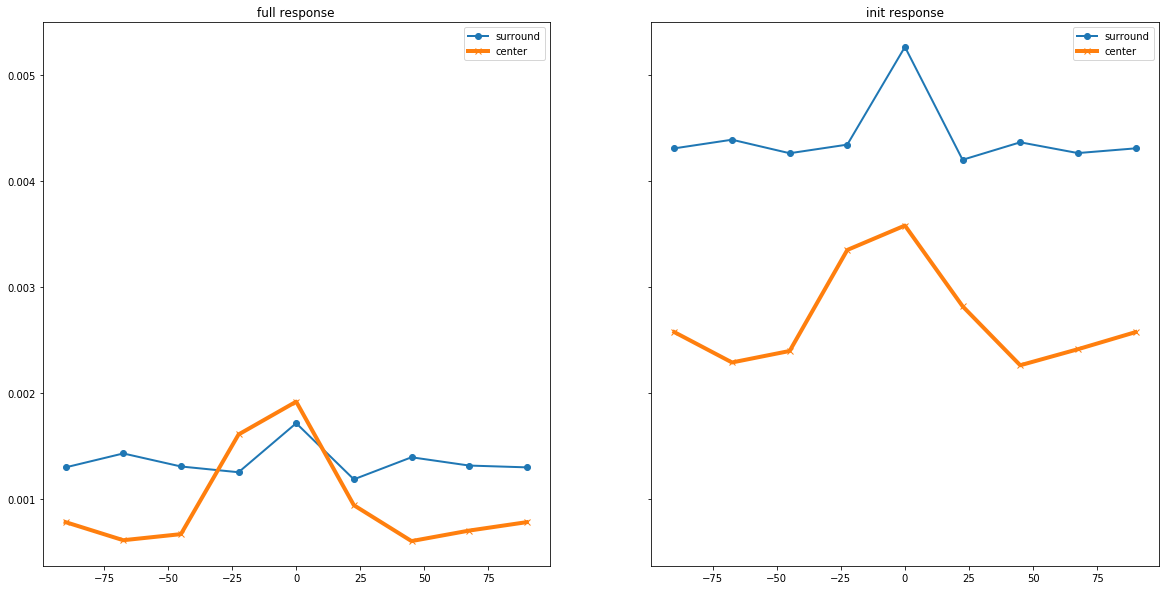

9b_longer
fetch 35 out of 72


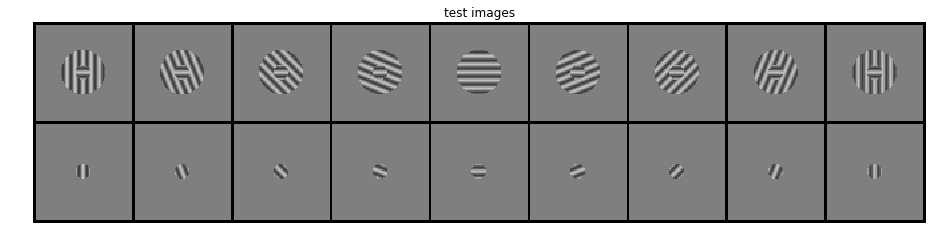

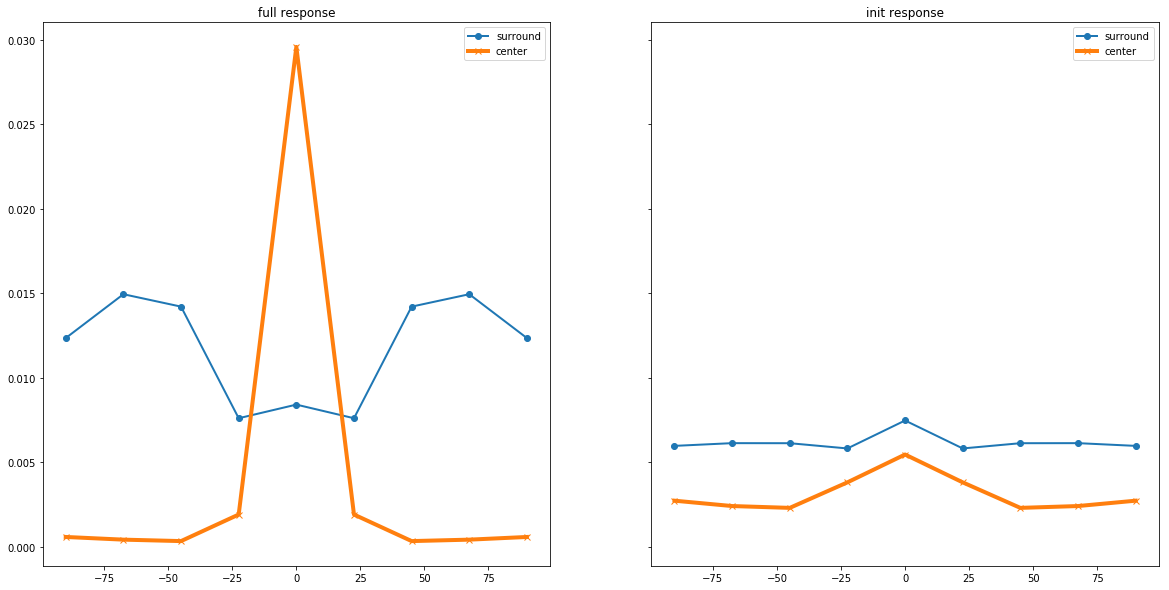

9b_longer_one_off
fetch 36 out of 72


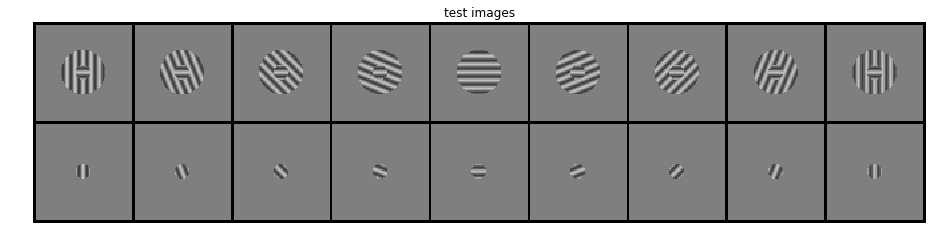

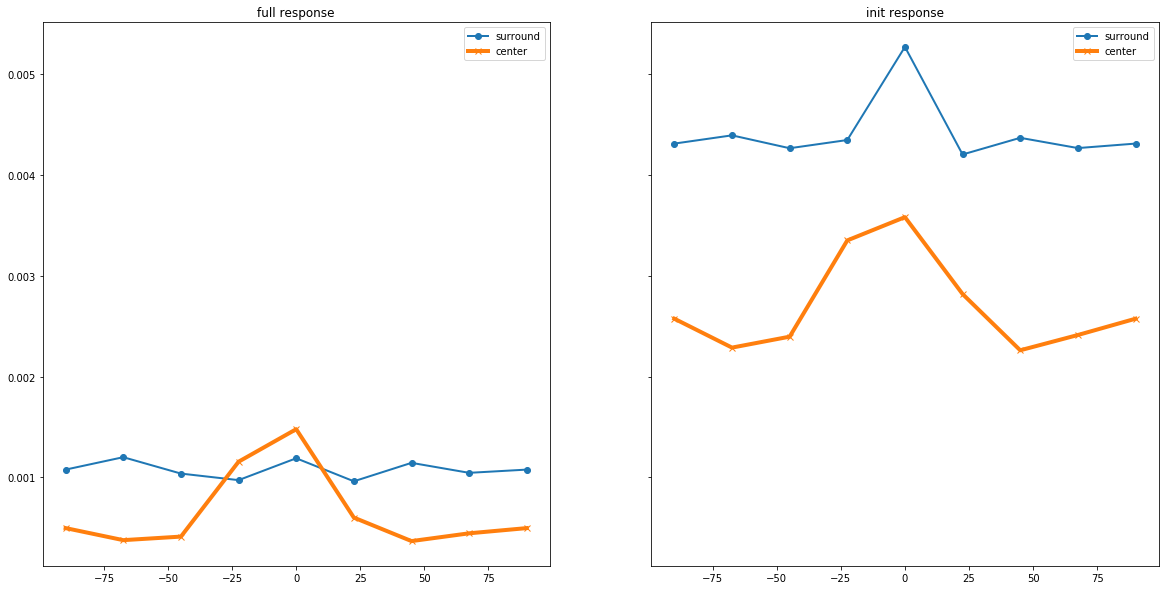

9b_longer_one_off_other
fetch 34 out of 72


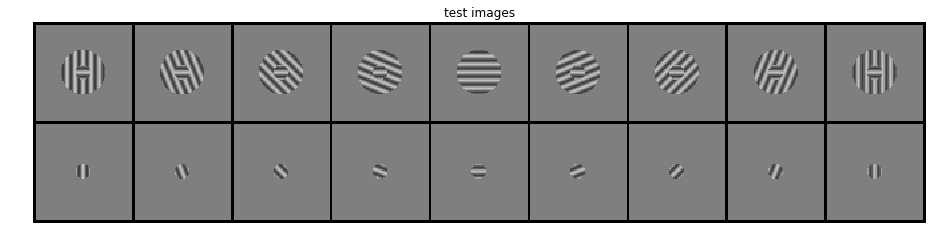

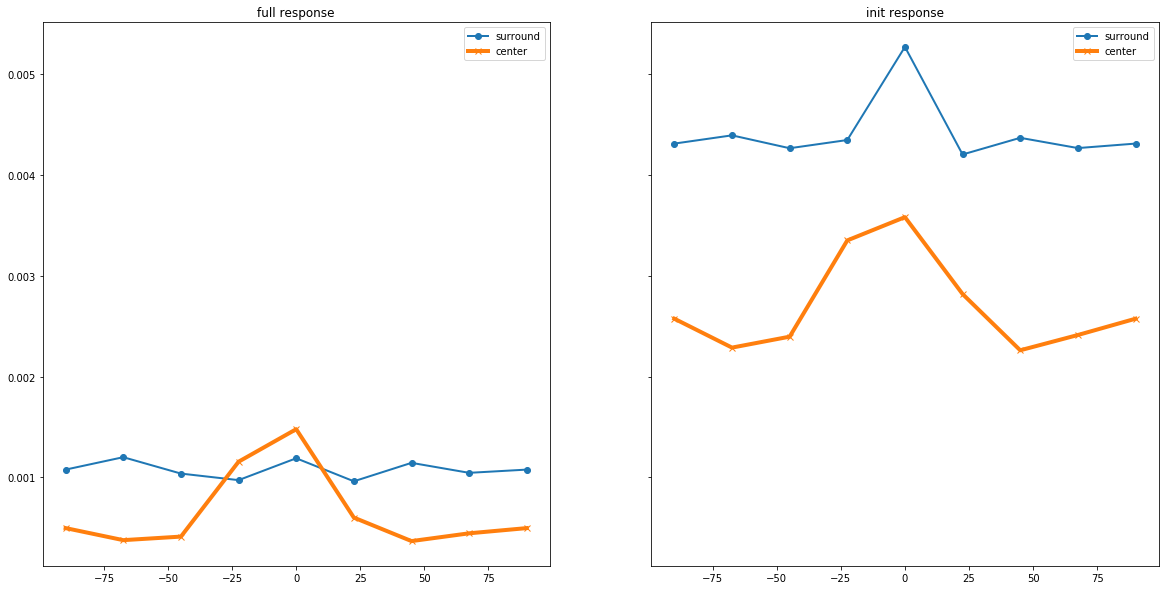

9c
fetch 35 out of 72


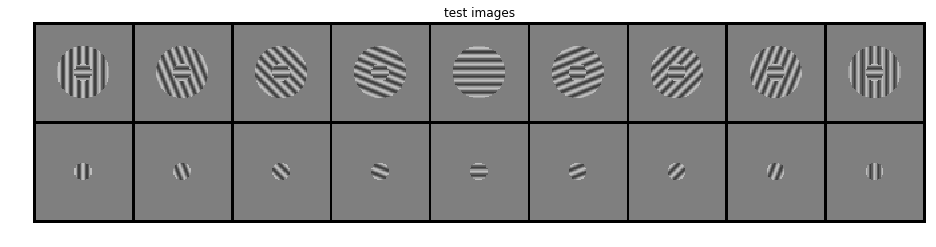

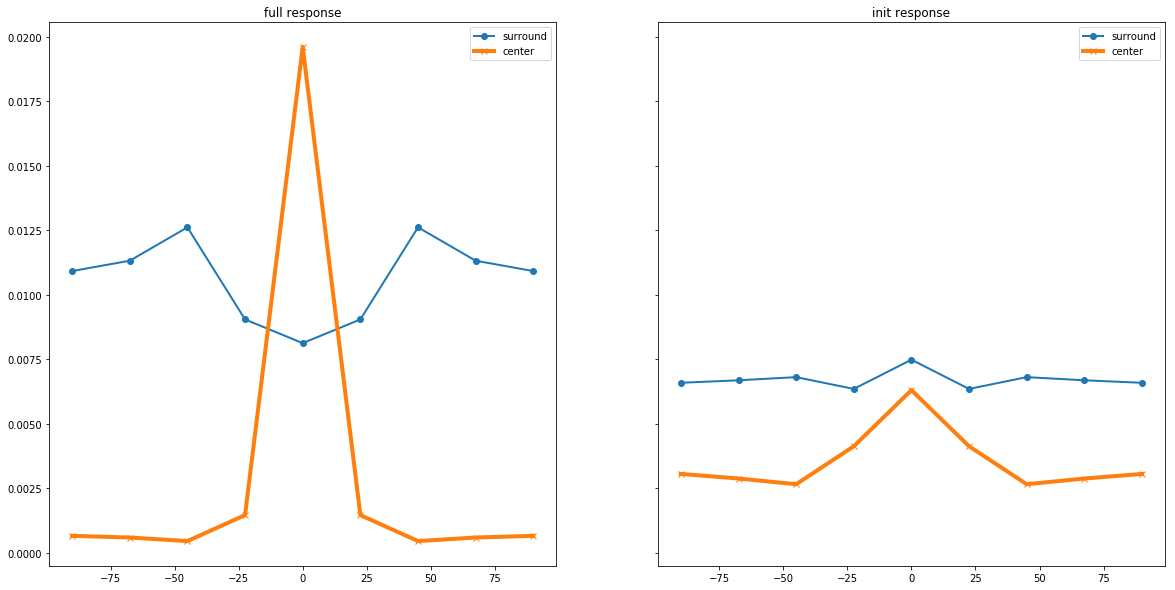

9c_one_off
fetch 36 out of 72


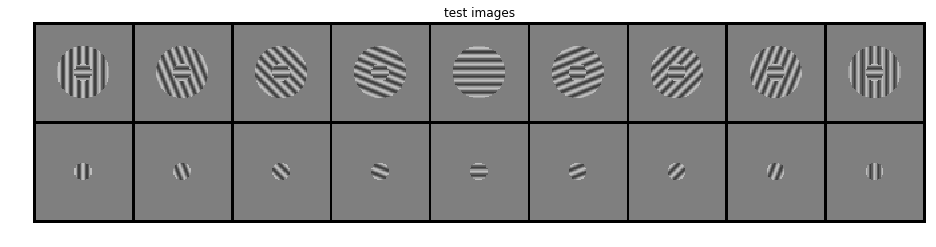

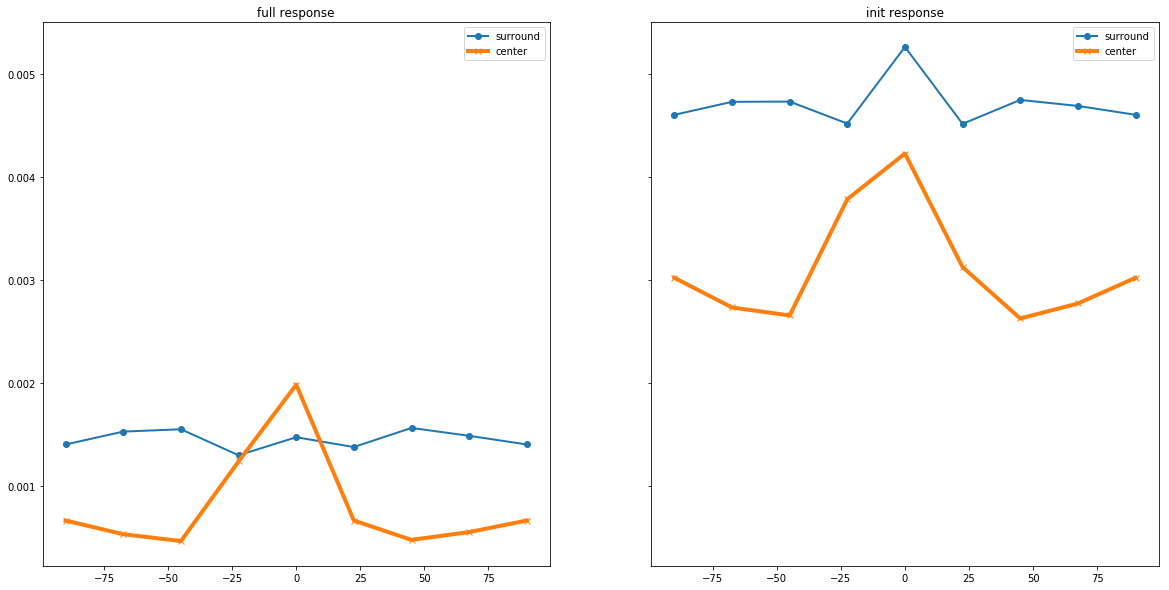

9c_one_off_other
fetch 34 out of 72


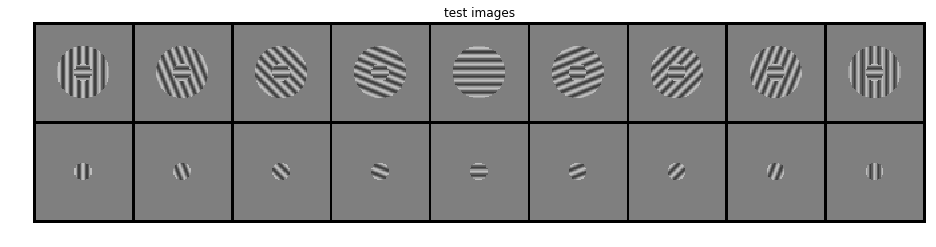

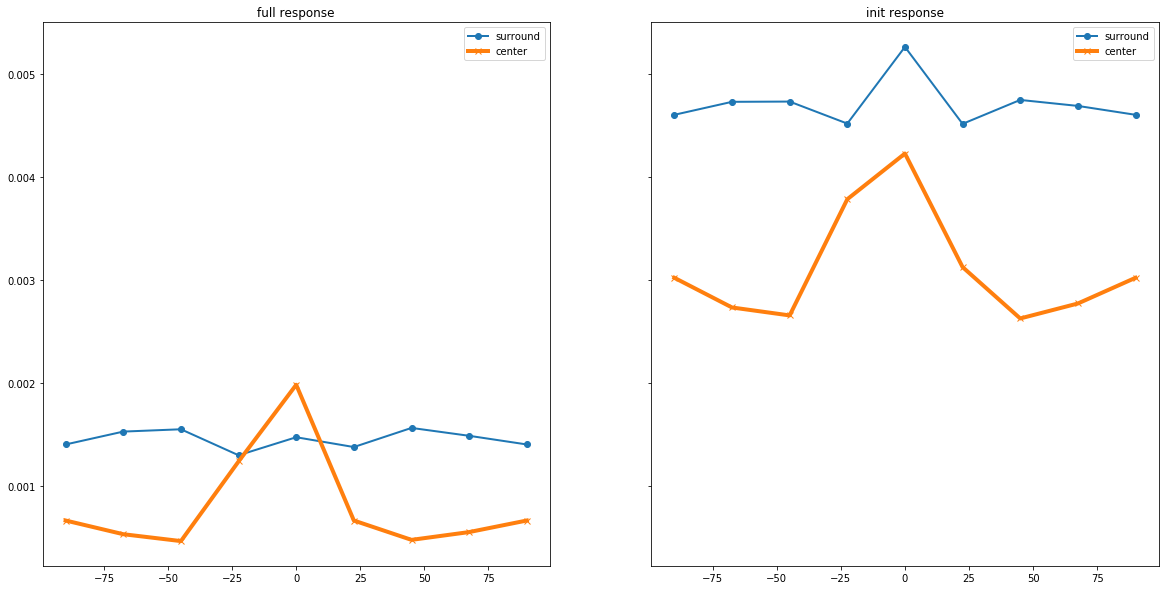

9d
fetch 35 out of 72


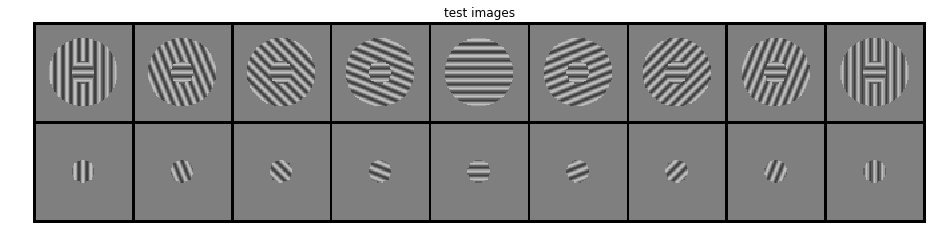

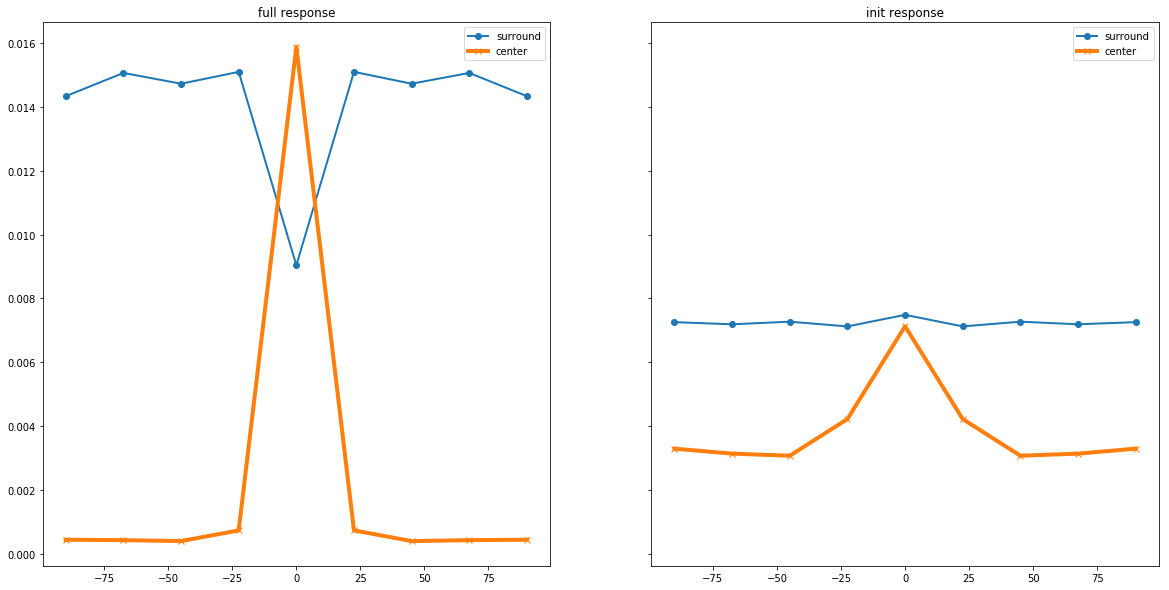

9d_one_off
fetch 36 out of 72


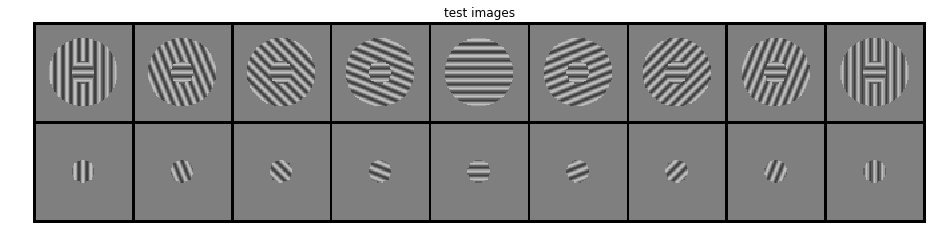

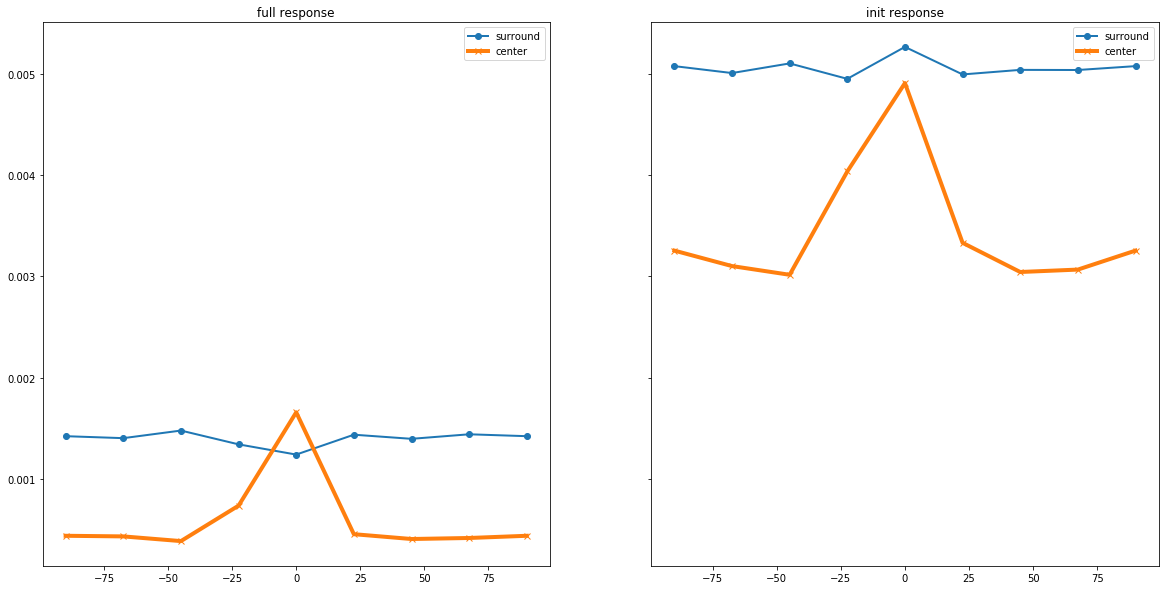

9d_one_off_other
fetch 34 out of 72


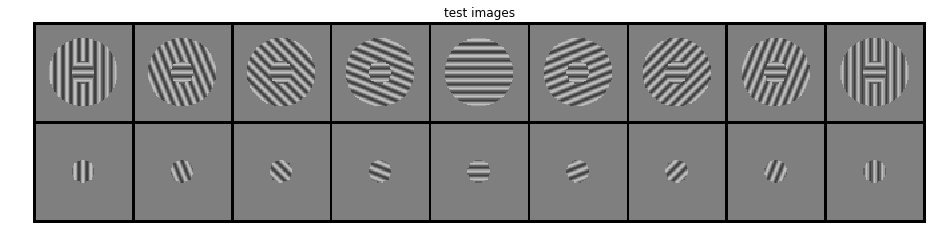

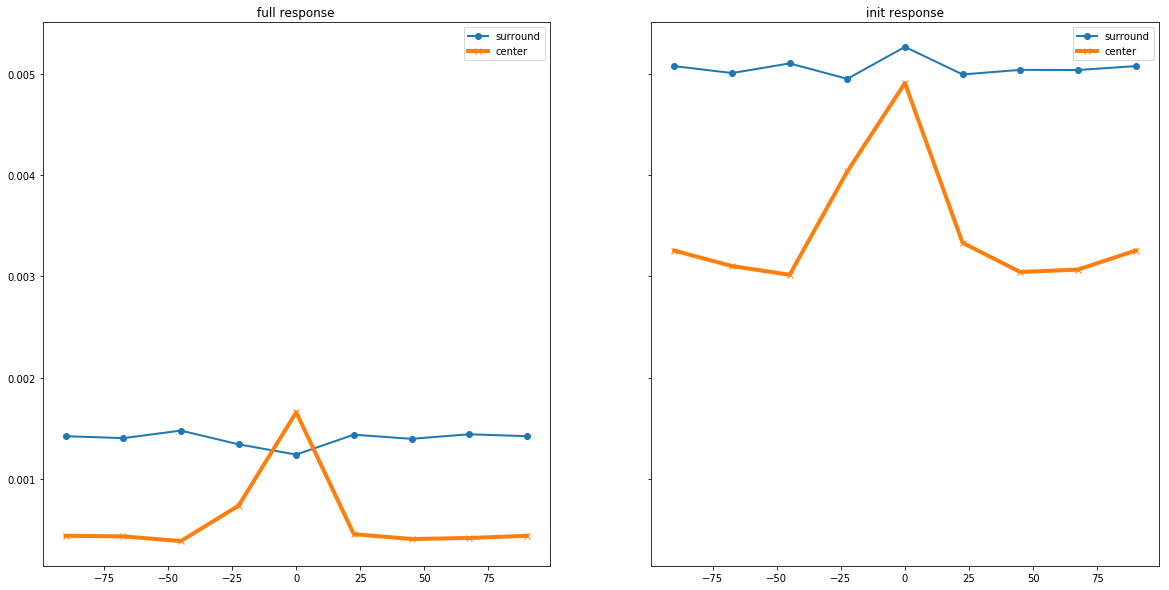

9e
fetch 35 out of 72


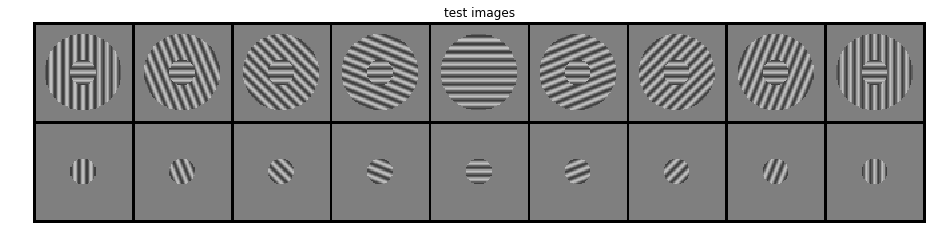

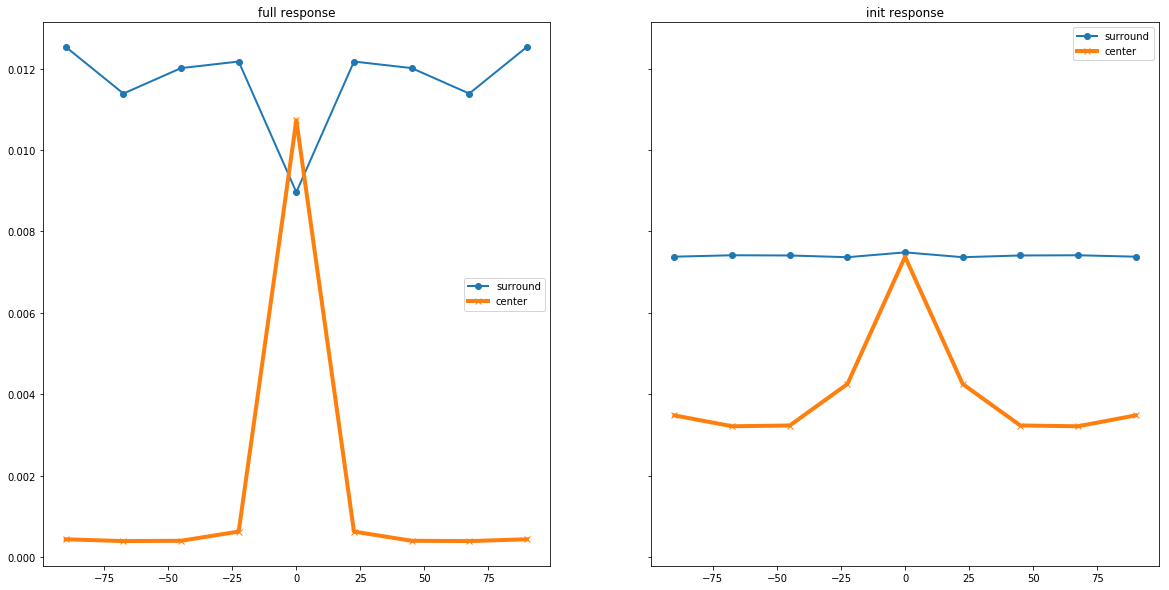

9e_one_off
fetch 36 out of 72


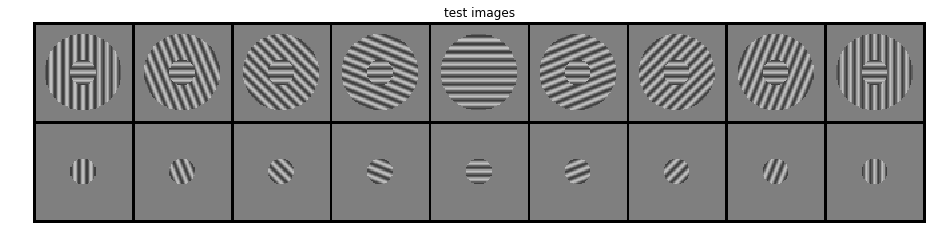

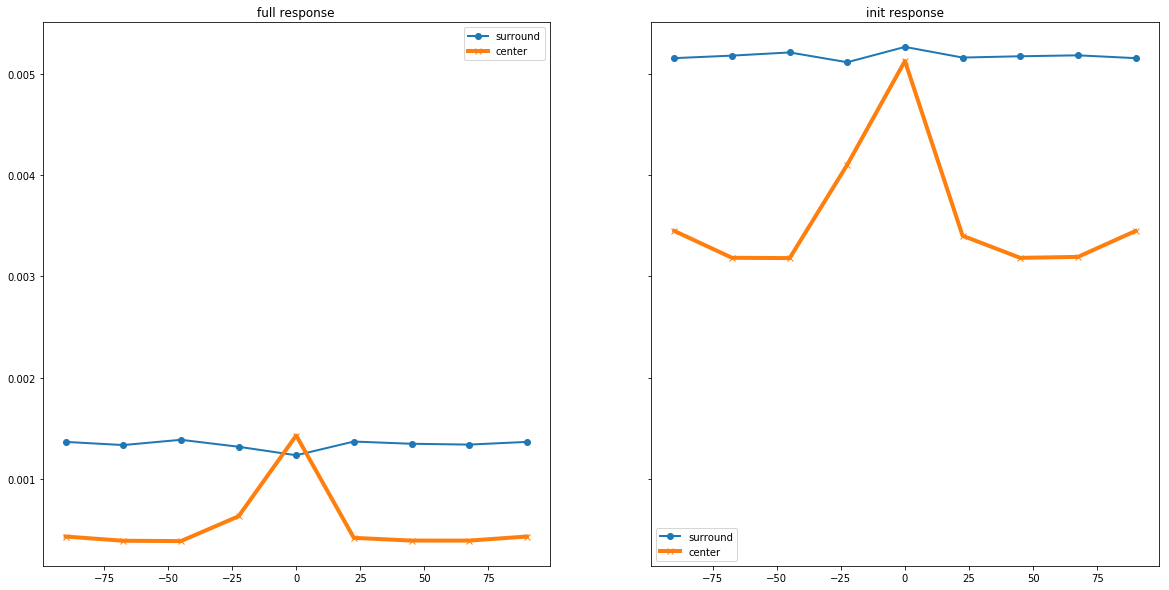

9e_one_off_other
fetch 34 out of 72


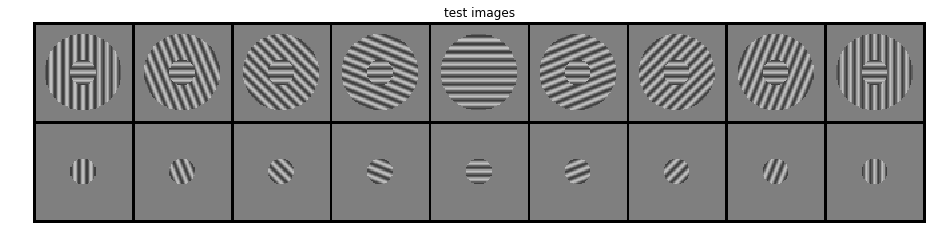

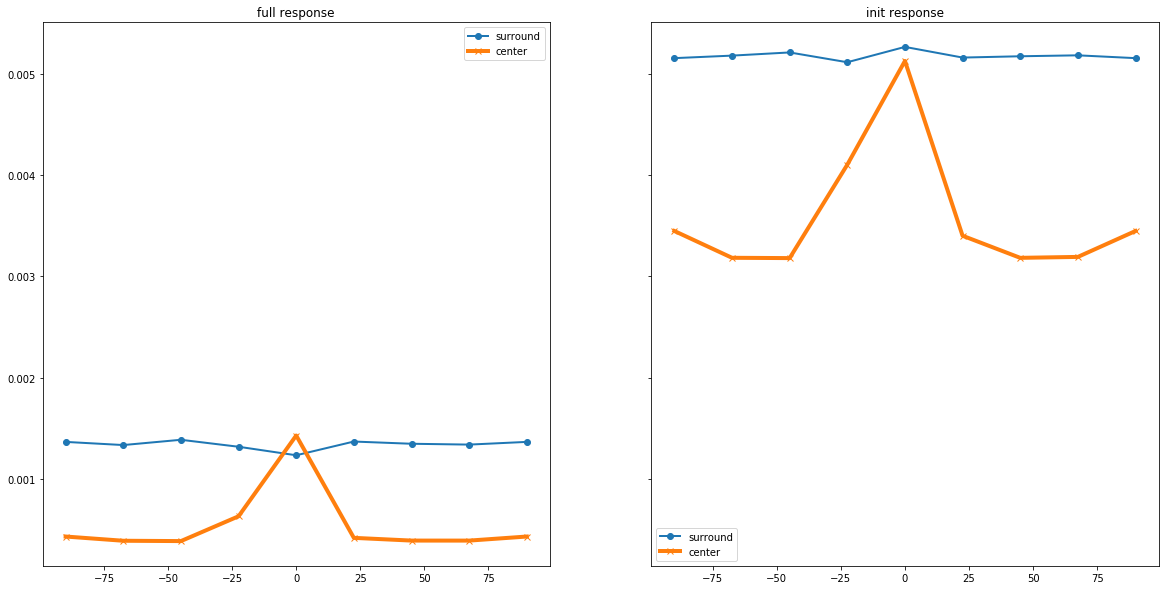

In [9]:
fig9_wrapper()
# I think the fickleness for position is due to inhibition among adjacent neurons...
# While inhibition among nearby neurons sounds right,
# I don't think real neurons are that fickle w.r.t location.
# At least, I don't believe V1 recording results will change this dramatically w.r.t such tiny location change.